## Goals:

**1. Determine the primary drivers of sentiment in the flavor text of Magic: The Gathering cards.**

**2. Develop a model to predict the sentiment of flavor text in Magic: The Gathering cards.**

In [1]:
# imports and display options

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

import prepare as p

pd.set_option('display.max_colwidth', -1)

# Acquire

1. A CSV, containing an up to date breakdown of each Magic card that has been printed so far, was obtained from MTGJSON.com. Each row represented a card or a version of a card.The dataframe contained 50,412 rows and 71 columns.

2. The CSV was read into a pandas dataframe

# Prepare

1. Restricted dataframe to only to columns I considered to be relevant. (colorIdentity, types, convertedManaCost, rarity, flavorText, isPaper)
 
2. Restricted dataframe to only rows containing cards that exist in physical form

3. Restricted dataframe to only row containing a flavor text

4. Restricted dataframe to only rows with a single color-identity

5. Merged rows with similar or overlapping types into one of the seven major game types

6. Restricted dataframe to include only rows with a single type belonging to one of the major game types

7. Cleaned up flavor text then aggregated on flavorText in an attempt to eliminate duplicates. This game me some success. However, it is likely that a few duplicates remain.

8. Reordered columns

9. Restricted dataframe to rows with English flavor text 

10. Dropped rows with duplicates I happened to spot

11. Added sentiment column showing compound sentiment score using VADER

12. Added intensity column showing the absolute value of the compound sentiment score 

In [2]:
# load and prepare data
#df = p.prepare_mgt(p.wrangle_mtg())

In [3]:
#df.to_csv('mtgprep.csv', index=False)

In [4]:
df = pd.read_csv('mtgprep.csv')

In [5]:
df=df.drop([7968,6562]) # drop found duplicates

In [6]:
df=df.rename(columns={'colorIdentity':'color','convertedManaCost':'cost','flavorText':'flavor'})

In [7]:
df.head(5)

,color,types,cost,rarity,flavor,sentiment,intensity
0,Green,Creature,5.0,common,""" . . . And the third little boar built his house out of rootwalla plates . . . .""",0.0000,0.0000
1,Black,Creature,1.0,common,""" . . . Cao Pi, Cao Rui, Fang, Mao, and briefly, Huan— The Sima took the empire in their turn. . . .""",0.0000,0.0000
2,Blue,Creature,5.0,uncommon,""" . . . When the trees bow down their heads, The wind is passing by.""",0.0000,0.0000
3,White,Creature,4.0,uncommon,""" . . . and you must also apply for an application license, file documents 136(iv) and 22-C and -D in triplicate, pay all requisite fees, request a . . .""",-0.1027,0.1027
4,Green,Creature,4.0,common,"""'Air superiority?' Not while our archers scan the skies.""",0.0000,0.0000


In [8]:
df = df.round(2)

# Explore

### What does the data look like?

The fully prepared data frame contains:

1. 12,448 rows and 7 columns
2. four features representing how the card is categorized (datatype object)
3. one feature representing Mana cost of the card (datatype float64)


In [9]:
df.shape

(12448, 7)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12448 entries, 0 to 12449
Data columns (total 7 columns):
color        12448 non-null object
types        12448 non-null object
cost         12448 non-null float64
rarity       12448 non-null object
flavor       12448 non-null object
sentiment    12448 non-null float64
intensity    12448 non-null float64
dtypes: float64(3), object(4)
memory usage: 778.0+ KB


### Observations:

1. mean sentiment in slightly negative at -.02, however it is very close to zero
2. median sentiment is 0 

3. mean intensity is .32 
4. median intensity is .32 

This suggests that both sentiment and intensity are normally distributed.

### Hypothesis: 
It is possible that there are a large amount of cards that have a sentiment score of 0 . If this is true, and if the cards that had a positive score were normally distributed around .32 and the negative ones around -.32 that would explain these numbers. it would also explain the large standard deviation .42 in sentiment.


observations:

1. sentiment scores ranged from -.98 to .95
2. intensity scores ranged from 0 to .98

This suggests the flavor text covers a wide range of sentimint values. 

In [11]:
df.describe()

,cost,sentiment,intensity
count,12448.00000,12448.000000,12448.000000
mean,3.17541,-0.024540,0.321109
std,1.61158,0.423045,0.276496
min,0.00000,-0.980000,0.000000
25%,2.00000,-0.340000,0.000000
50%,3.00000,0.000000,0.320000
75%,4.00000,0.300000,0.540000
max,15.00000,0.950000,0.980000


### How balanced are the features in  the data set?

* Color counts are about even
* types are very unevenly distributed Creature is the largest with 6978 and Planeswalker is the smallest with 1
* Cost appears normally distributed around 3
* rarity is unevenly distributed with common being the largest with 5927 and mythic being the smallest at 163 


In [49]:
for column in df.columns:
    
    if column not in ('sentiment','flavor'):
        print(f'{column} value counts')
        print(df[f'{column}'].value_counts())
        print('')

color value counts
Red      2563
White    2556
Black    2473
Green    2453
Blue     2403
Name: color, dtype: int64

types value counts
Creature        6978
Instant         2016
Sorcery         1762
Enchantment     1573
Land            77  
Artifact        41  
Planeswalker    1   
Name: types, dtype: int64

cost value counts
3.0     3037
2.0     2882
4.0     2289
1.0     1734
5.0     1397
6.0     645 
7.0     244 
8.0     90  
0.0     80  
9.0     29  
10.0    11  
11.0    5   
12.0    2   
15.0    1   
14.0    1   
0.5     1   
Name: cost, dtype: int64

rarity value counts
common      5927
uncommon    3643
rare        2715
mythic      163 
Name: rarity, dtype: int64

intensity value counts
0.00    3588
0.44    344 
0.30    326 
0.36    320 
0.38    298 
       ...  
0.94    8   
0.07    5   
0.95    5   
0.96    2   
0.98    1   
Name: intensity, Length: 98, dtype: int64



### How many cards have a sentiment/intensity score of zero?

* 0 is the most frequently occurring value (count = 3588)

* -.3 is second (count = 253)

* .44 is third (count =253)

In [12]:
df.sentiment.value_counts().head(10)

 0.00    3588
-0.30    253 
 0.44    214 
 0.36    213 
 0.49    165 
-0.38    164 
-0.34    160 
-0.60    157 
 0.42    145 
-0.48    134 
Name: sentiment, dtype: int64

### What is frequency distribution of sentiment scores?

* Looking at the frquency distributions it appears that the hypothysis is correct. 
* Taken by themselves, positive and negative sentiment cards appear to be somewhat normally distributed. 
* When viewed as a whole the data set are not at all normally distributed.

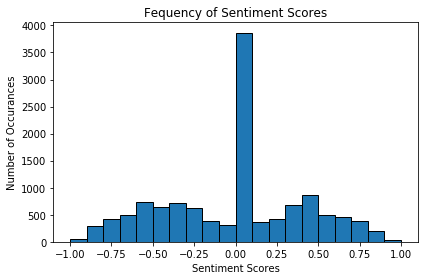

In [13]:
bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



sentiment = df['sentiment']

plt.hist(sentiment,bins=bins,edgecolor='black')


plt.title('Fequency of Sentiment Scores')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

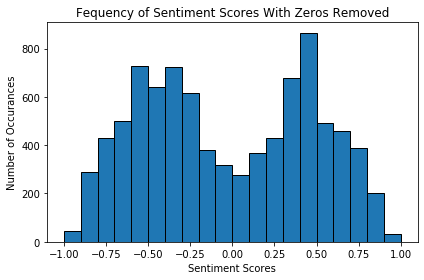

In [14]:
bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



sentiment = df.sentiment[df.sentiment!=0]

plt.hist(sentiment,bins=bins,edgecolor='black')


plt.title('Fequency of Sentiment Scores With Zeros Removed')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

### What is frequency distribution of intensity scores?

* The most frequent intensity score is 0. 
* Intensity scores with a non-zero value seem to be normally distributed around .4.

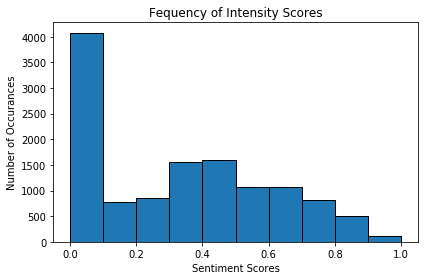

In [32]:
bins =[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



intensity = df['intensity']

plt.hist(intensity,bins=bins,edgecolor='black')


plt.title('Fequency of Intensity Scores')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

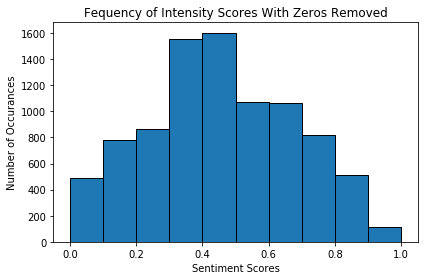

In [30]:
bins =[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



intensity = df.intensity[df.intensity!=0]

plt.hist(intensity,bins=bins,edgecolor='black')


plt.title('Fequency of Intensity Scores With Zeros Removed')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

### What do high, low, and zero sentiment flavor texts look like?

* Highest Sentiment flavor text is: Some spectators love an underdog, but others are just as happy to support a proven winner.	

* Lowest sentiment flavor text is: "We mourn our dead. We shroud our dead. We bury our dead. Too often, it seems, we must kill our dead again."

* A zero-sentiment flavor text is: " . . . And the third little boar built his house out of rootwalla plates . . . ."


In [36]:
df[['flavor','sentiment']].sort_values('sentiment',ascending=False).head()

,flavor,sentiment
9887,"Some spectators love an underdog, but others are just as happy to support a proven winner.",0.95
8850,"MORE TO LOVE: Friendly, nature-loving, Bunyonesque SEM seeks SEF looking for a huge commitment. . . . seeks atog prince",0.94
5313,"""When I wish to be strong, I train. When I wish to be wise, I study. When I wish to rest, I start again.""",0.93
11773,"To become an officer, an Icatian Soldier had to pass a series of tests. These evaluated not only fighting and leadership skills, but also integrity, honor, and moral strength.",0.93
7967,"If you find yourself and a friend being chased by a King Cheetah, you have but one chance: Trip your friend. —Suq'Ata wisdom",0.93


In [37]:
df[['flavor','sentiment']].sort_values('sentiment',ascending=True).head()

,flavor,sentiment
5112,"""We mourn our dead. We shroud our dead. We bury our dead. Too often, it seems, we must kill our dead again.""",-0.98
9135,"No one spoke. There was no need. The threat of the Eldrazi presented a simple choice: lay down your weapons and die for nothing, or hold them fast and die for something.",-0.96
2943,"""No more fear. No more failure. No more death. No more!""",-0.96
9904,"Some tried cremating their dead to stop the ghoulcallers. But the dead returned, furious about their fate.",-0.95
11432,"There are laws against it, but the dead have no one to complain to and the living are too frightened to investigate.",-0.95


In [39]:
df[['flavor','sentiment']][df.sentiment==0].head(10)

,flavor,sentiment
0,""" . . . And the third little boar built his house out of rootwalla plates . . . .""",0.0
1,""" . . . Cao Pi, Cao Rui, Fang, Mao, and briefly, Huan— The Sima took the empire in their turn. . . .""",0.0
2,""" . . . When the trees bow down their heads, The wind is passing by.""",0.0
4,"""'Air superiority?' Not while our archers scan the skies.""",0.0
9,"""'I have arrived,' bellowed Brawn, and the plane shuddered.""",0.0
10,"""'I'll show you how to handle the treefolk!' the giant bragged, and he strode off into the forest. Two days later he returned, his face masked in sap and a nest behind his ear. None dared ask who won.""",0.0
12,"""'I've seen hornworms big as a man's fist,' the traveler said, and nodded soberly when our jaws went slack at his ignorance.""",0.0
13,"""'Invincible' is just a word.""",0.0
16,"""'Ownership' is such a gray area.""",0.0
19,"""'Tis distance lends enchantment to the view, And robes the mountain in its azure hue.""",0.0


### How does sentiment relate to each feature?

* Because of the shape of our data, stats tests to determine if features are related such as T-test and correlation or not usable for measuring sentiment.

### Color

* three colors have positive mean sentiment scores white, blue, and green
* two colors have negative mean scores black and red
* four colors have mean sentiment values that are less than .1 away from zero, white, blue, gree, red and green
* one color with the most extream mean sentiment score was black at -.12
* all colors have a mean and median sentiment score of 0
* between 24-34% of values for each color are zero

* looking at the frequency distribution of sentiment scores they seem to follow the same general distribution as the overall data.
* The most notable differance is that black has noticably more negative sentament scores than positive ones. This is reflected in its more extream than usual mean sentiment score.

In [77]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.mean()
      
    print(f'{color}: {round(number,2)}')

White: 0.03
Blue: 0.01
Black: -0.12
Red: -0.06
Green: 0.01


In [70]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.median()
      
    print(f'{color}: {number}')

White: 0.0
Blue: 0.0
Black: 0.0
Red: 0.0
Green: 0.0


In [78]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.mode()
      
    print(f'{color}: {number}')

White: 0    0.0
dtype: float64
Blue: 0    0.0
dtype: float64
Black: 0    0.0
dtype: float64
Red: 0    0.0
dtype: float64
Green: 0    0.0
dtype: float64


In [76]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    zeros = df[df.color==f'{color}'][df.sentiment==0].sentiment.count()
    totals = df[df.color==f'{color}'].sentiment.count()
      
    print(f'{color}: {round(zeros/totals,2)}')

White: 0.25
Blue: 0.33
Black: 0.24
Red: 0.29
Green: 0.34


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


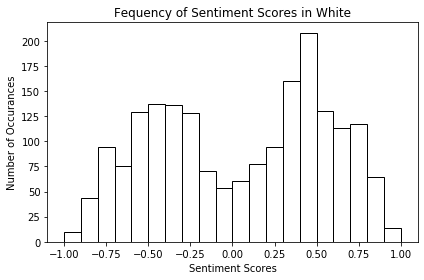

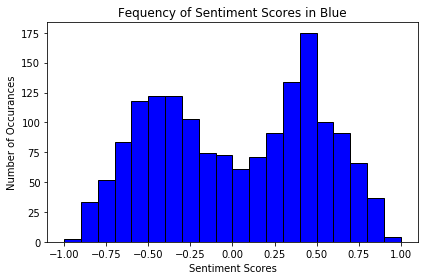

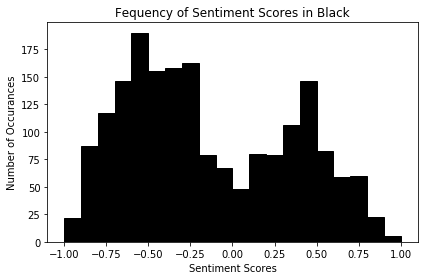

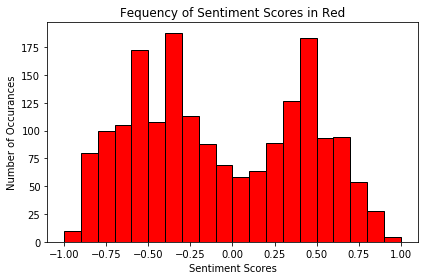

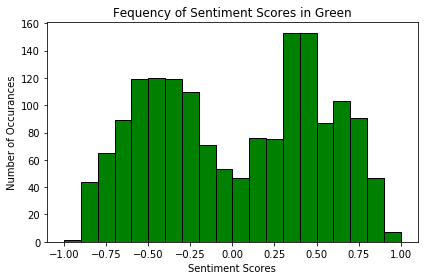

In [67]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:


    bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



    sentiment = df.sentiment[df.sentiment!=0][df.color==f'{color}']

    plt.hist(sentiment,bins=bins,edgecolor='black',color=f'{color}')


    plt.title(f'Fequency of Sentiment Scores in {color}')
    plt.xlabel('Sentiment Scores')
    plt.ylabel('Number of Occurances')





    plt.tight_layout()

    plt.show()

### Types

In [79]:
df.types.value_counts()

Creature        6978
Instant         2016
Sorcery         1762
Enchantment     1573
Land            77  
Artifact        41  
Planeswalker    1   
Name: types, dtype: int64

In [82]:
types = ['Creature','Instant','Sorcery','Enchantment','Land','Artifact','Planeswalker']

for item in types:

    number = df[df.types==f'{item}'].sentiment.mean()
      
    print(f'{item}: {round(number,2)}')

Creature: -0.02
Instant: -0.02
Sorcery: -0.04
Enchantment: -0.02
Land: -0.07
Artifact: 0.04
Planeswalker: 0.58


In [ ]:
plt.bar(df.colorIdentity,df.sentiment)

In [ ]:
df.colorIdentity.plot()
    

In [ ]:
df[df.sentiment==0].count()/df.sentiment.count()

# remove 7968 6562

In [42]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.mean()
      
    print(f'{color}: {number}')

White: 0.032910798122065744
Blue: 0.009234290470245524
Black: -0.11655074807925604
Red: -0.057619976589933695
Green: 0.009836934366082338


In [43]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'][df.sentiment!=0].sentiment.mean()
      
    print(f'{color}: {number}')

White: 0.04390396659707727
Blue: 0.013756974581525104
Black: -0.1538868126001069
Red: -0.08078774617067837
Green: 0.01480368098159508


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [ ]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.colorIdentity==f'{color}'].intensity.mean()
      
    print(f'{color}: {number}')

In [41]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].intensity.median()
      
    print(f'{color}: {number}')

White: 0.36
Blue: 0.28
Black: 0.36
Red: 0.34
Green: 0.3


In [ ]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.colorIdentity==f'{color}'][df.sentiment!=0].sentiment.median()
      
    print(f'{color}: {number}')

In [ ]:
df[df.sentiment==0].colorIdentity.value_counts()

In [ ]:
rarity = ['common','uncommon','rare','mythic']

for grade in rarity:

    number = df[df.rarity==f'{grade}'].sentiment.mean()
      
    print(f'{grade}: {number}')

In [ ]:
rarity = ['common','uncommon','rare','mythic']

for grade in rarity:

    number = df[df.rarity==f'{grade}'].intensity.median()
      
    print(f'{grade}: {number}')

In [ ]:
types = ['Artifact','Creature','Enchantment','Land','Planeswalker','Instant','Sorcery']

for group in types:

    number = df[df.types==f'{group}'].sentiment.mean()
      
    print(f'{group}: {number}')

In [ ]:
types = ['Artifact','Creature','Enchantment','Land','Planeswalker','Instant','Sorcery']

for group in types:

    number = df[df.types==f'{group}'].intensity.mean()
      
    print(f'{group}: {number}')

In [ ]:
costs = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0]

for cost in costs: 

    number = df[df.convertedManaCost==float(f'{cost}')].sentiment.mean()
    
    number2 = df[df.convertedManaCost==float(f'{cost}')].intensity.mean()
      
    print(f'{cost}: {number}  {number2}')

# Look at a frquency distribution of total cards into sentament and intensity buckets

# Examin frequency of positive and negative sentament 